In [6]:
import numpy as np
import math

import math
import numpy as np

def rotate_points_about_origin(points, angle):
    """
    Rotates each point in 'points' about the origin by 'angle' radians in-place.
    """
    rotation_matrix = np.array([
        [math.cos(angle), -math.sin(angle)],
        [math.sin(angle),  math.cos(angle)]
    ])
    # Apply rotation in-place
    for i in range(len(points)):
        points[i] = rotation_matrix @ points[i]

def generate_noisy_three_edges_shared_origin_with_rotation(n, k, noise_std=0.01, seed=None):
    """
    Generates a shape consisting of three edges of lengths 2, 3, and 4,
    all emanating from a shared origin (0, 0). Each edge is discretized
    into 'n' points. Rotates and adds Gaussian noise 'k' times, returning
    a list of (points, simplices) pairs.

    :param n: Number of points on each edge, including the origin. Hence each edge 
              will have 'n' total points, with the origin being common to all edges.
    :param k: Number of rotated/noisy versions to generate.
    :param noise_std: Standard deviation of the added Gaussian noise (zero-mean).
    :param seed: Seed for the random number generator.
    :return: A list of length 'k', where each entry is (points, simplices).
    """

    if seed is not None:
        np.random.seed(seed)

    # Edges: lengths = [2, 3, 4]
    edge_lengths = [2.0, 3.0, 4.0]

    # Generate 3 random angles in [0, 2π)
    edge_angles = np.random.uniform(0, 2*math.pi, size=3)

    # Build base points
    base_points = []
    # Origin
    base_points.append([0.0, 0.0])

    # For each edge of length L, generate (n - 1) additional points
    # from origin to distance L, in direction of 'theta'
    for length, theta in zip(edge_lengths, edge_angles):
        for j in range(1, n):
            # fraction goes from 1/(n-1) up to (n-1)/(n-1) = 1
            fraction = j / (n - 1)
            t = length * fraction
            x = t * math.cos(theta)
            y = t * math.sin(theta)
            base_points.append([x, y])

    base_points = np.array(base_points, dtype=float)

    # Build simplices
    num_vertices = 1 + 3 * (n - 1)  # 1 (origin) + 3 edges * (n-1) new points
    simplices_template = []

    # Add 0-simplices (vertices)
    for i in range(num_vertices):
        simplices_template.append([i])

    # For each of the 3 edges, add 1-simplices (edges) from origin -> first point
    # and then consecutive points along that edge.
    for edge_i in range(3):
        start = 1 + edge_i * (n - 1)
        # connect origin -> first point on this edge
        simplices_template.append([0, start])
        # connect consecutive points
        for v in range(start, start + (n - 2)):
            simplices_template.append([v, v + 1])

    # Make a copy of the base points (before applying rotation/noise)
    current_points = base_points.copy()

    # Generate k rotated/noisy versions
    results = []
    for _ in range(k):
        # Random rotation angle
        angle = np.random.uniform(0, 2*math.pi)
        rotate_points_about_origin(current_points, angle)

        # Add Gaussian noise except for the origin
        noise = np.random.normal(0.0, noise_std, current_points.shape)
        noise[0, :] = 0.0  # origin stays fixed
        current_points += noise

        # Make copies for the result
        points_copy = current_points.copy()
        simplices_copy = [s[:] for s in simplices_template]

        results.append((points_copy, simplices_copy))

    return results



import matplotlib.pyplot as plt

def plot_simplicial_complexes(results):
    """
    Plots each simplicial complex in the results list on its own figure,
    with fixed axis limits (-5 to 5) for both x and y axes.

    :param results: A list of (points, simplices) tuples.
    """
    for i, (points, simp_comp) in enumerate(results):
        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Plot the vertices
        ax.scatter(points[:, 0], points[:, 1], color='black', s=1)
        
        # Plot the edges (1-simplices)
        for simplex in simp_comp:
            simplex_points = points[simplex, :]
            if len(simplex) > 1:
                ax.plot(simplex_points[:, 0], simplex_points[:, 1], 'k-')
        
        # Fix the axis limits so every plot shows the region from -5 to 5
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_aspect('equal')

        plt.show()

        


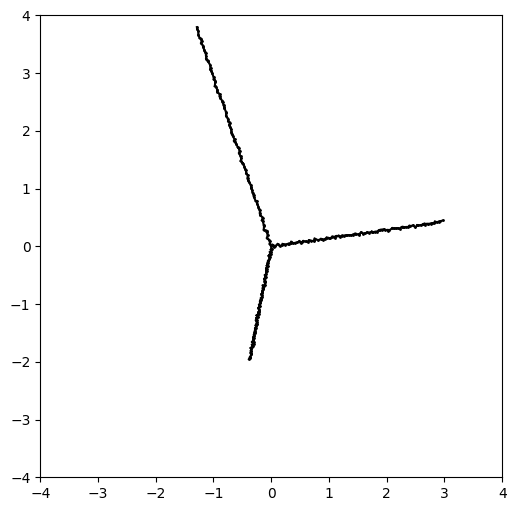

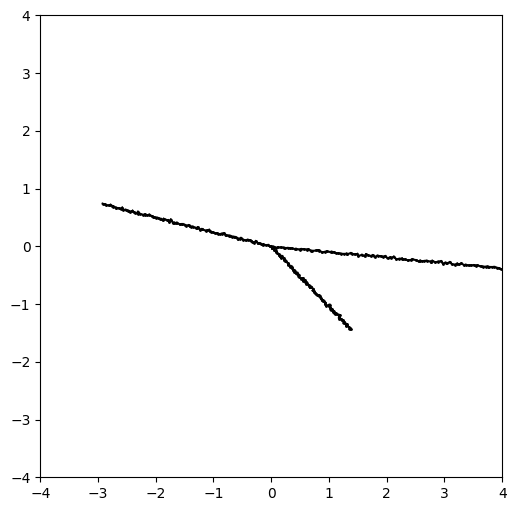

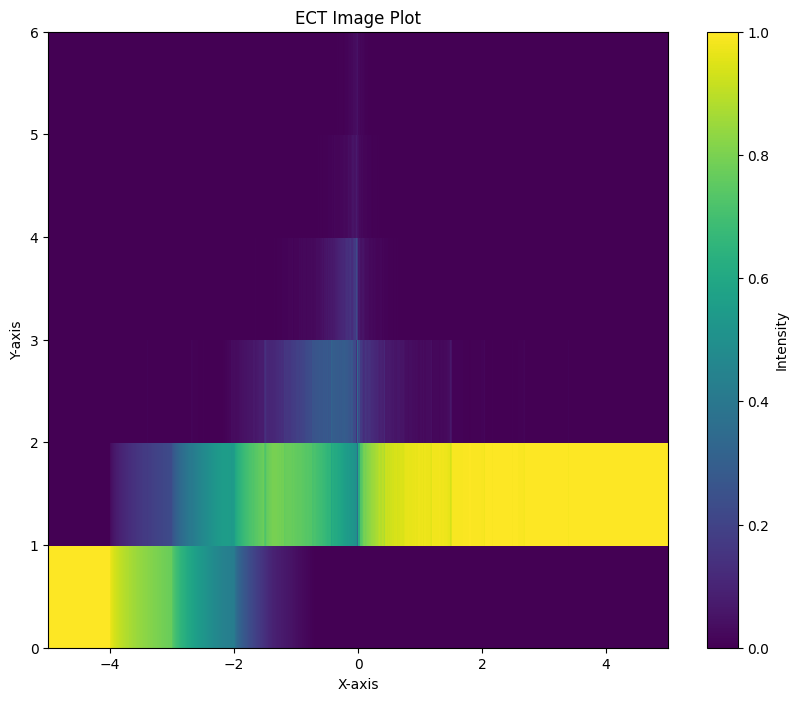

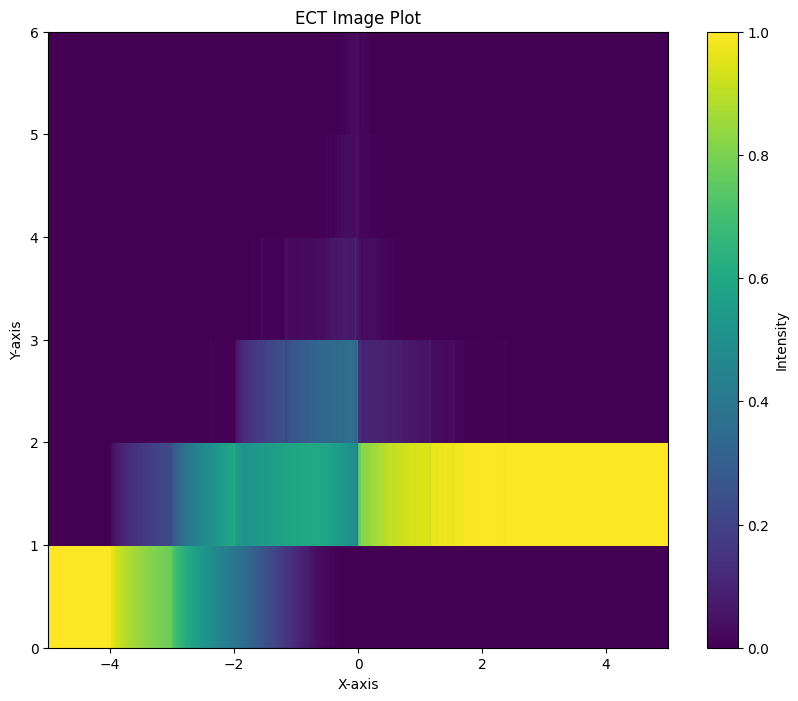

In [7]:
import My_ECT as detect
# Generate a list with exactly 1 entry, then unpack the first entry
results = generate_noisy_three_edges_shared_origin_with_rotation(100, 1, noise_std=0.01, seed=1)
(data1, simplex1) = results[0]

results2 = generate_noisy_three_edges_shared_origin_with_rotation(100, 1, noise_std=0.01, seed=2)
(data2, simplex2) = results2[0]
plot_simplicial_complexes([(data1, simplex1), (data2, simplex2)])
ect_image1 = detect.EctImg(simplex1, data1, k=1000, xinterval=(-5., 5.), xpoints=5000, yinterval=(0., 6), ypoints=6, factor=3)
ect_image2 = detect.EctImg(simplex2, data2, k=1000, xinterval=(-5., 5.), xpoints=5000, yinterval=(0., 6), ypoints=6, factor=3)
ect_image1.plot()
ect_image2.plot()

### pca with kernel

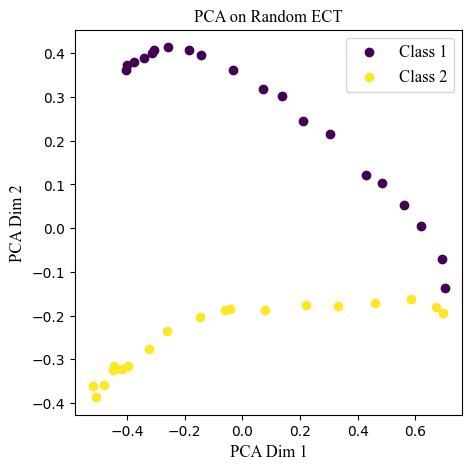

In [47]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    """
    Compute the Wasserstein distance between two empirical measures,
    each represented as a k x N array (each row is a function sampled at N points),
    incorporating the delta_x factor for uniformly sampled points.

    Parameters:
        empirical1 : np.array of shape (k, N)
            The first set of functions.
        empirical2 : np.array of shape (k, N)
            The second set of functions.
        p : float, default 2
            The order of the norm (p=2 for L2, p=1 for L1).
        delta_x : float, default 1.0
            The spacing between sample points, e.g.,
            (x_max - x_min) / (N - 1).

    Returns:
        float
            The computed Wasserstein distance.
    """
    # Compute the cost matrix using the Minkowski metric.
    # cdist returns (sum_i |f_i - g_i|^p)^(1/p), so we multiply by (delta_x)^(1/p)
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    
    # Solve the assignment problem to obtain the best matching.
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Compute the average p-th power cost for the matched pairs.
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    
    # Return the p-th root of the average cost.
    return avg_cost_p ** (1.0 / p)

def compute_distance_matrix(measures, p=2, delta_x=1.0):
    """
    Given a list 'measures' of empirical measures (each a k x N array),
    compute the pairwise Wasserstein distance matrix.

    Parameters:
        measures : list of np.array
            Each element is an empirical measure (k functions sampled at N points).
        p : float, default 2
            The order of the norm.
        delta_x : float, default 1.0
            The spacing between the sample points.

    Returns:
        np.array
            An n x n symmetric matrix of Wasserstein distances.
    """
    n = len(measures)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = wasserstein_distance(measures[i], measures[j], p=p, delta_x=delta_x)
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    return distance_matrix

def construct_rbf_kernel(distance_matrix, sigma=None):
    """
    Construct an RBF kernel from the distance matrix.
    If sigma is not provided, the median of the distances is used.

    Parameters:
        distance_matrix : np.array
            The matrix of pairwise Wasserstein distances.
        sigma : float or None, default None
            The RBF kernel width parameter.

    Returns:
        np.array
            The RBF kernel matrix.
    """
    if sigma is None:
        sigma = np.median(distance_matrix)
    kernel_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))
    return kernel_matrix


import numpy as np
import matplotlib.pyplot as plt

# 1) Import the kernel-related utilities you provided
# (Assuming they are already defined or imported from your code):
#   - wasserstein_distance
#   - compute_distance_matrix
#   - construct_rbf_kernel
# from your_file import wasserstein_distance, compute_distance_matrix, construct_rbf_kernel

# 2) Import KernelPCA for the "precomputed" kernel approach
from sklearn.decomposition import KernelPCA

###############################################################################
# 1) Generate data & compute Random ECT in (k x N) form
###############################################################################

shapes_class1 = generate_noisy_three_edges_shared_origin_with_rotation(n=100, k=20, noise_std=0.05, seed=1)
shapes_class2 = generate_noisy_three_edges_shared_origin_with_rotation(n=100, k=20, noise_std=0.05, seed=2)
all_shapes = shapes_class1 + shapes_class2  # total 40 shapes
random_ect_list = []  # We'll store each shape's Random ECT (k x N) as an element in this list

k_val = 1000      # same value you used for detect.RandomEct_2d
num_points = 3000 # same value you used for detect.RandomEct_2d

for i, (points, simp_comp) in enumerate(all_shapes):
    # The random ECT is a (k_val x num_points) array
    random_ect = detect.RandomEct_2d(simp_comp, points, k=k_val, interval=(-5., 1.), points=num_points)
    random_ect = np.array(random_ect)  # shape = (1000, 3000)
    random_ect_list.append(random_ect)


###############################################################################
# 2) Compute the Wasserstein-based RBF kernel
###############################################################################
# We first compute a distance matrix based on your "wasserstein_distance".
# Then we convert that distance matrix into an RBF kernel.

# Because you are sampling from x in [-5, 1] => total range = 6.0
# If you have 3000 sample points, delta_x ~ 6.0 / (3000 - 1).
delta_x = 6.0 / (num_points - 1)

# 2a) Pairwise Wasserstein distances
distance_matrix = compute_distance_matrix(random_ect_list, p=2, delta_x=delta_x)
# shape of distance_matrix => (40, 40) if you have 40 shapes total

# 2b) Construct RBF kernel from the distance matrix
# If sigma=None, it uses np.median(distance_matrix) by default
kernel_matrix = construct_rbf_kernel(distance_matrix, sigma=None)
# shape => (40, 40)

###############################################################################
# 3) KernelPCA in "precomputed" mode
###############################################################################
# Instead of using normal PCA on raw features, we pass the kernel matrix to KernelPCA.
# n_components=2 => reduce to 2D.

kpca = KernelPCA(n_components=2, kernel='precomputed')
kpca_random_2d = kpca.fit_transform(kernel_matrix)  
# shape => (40, 2)

###############################################################################
# 4) Plot the 2D KernelPCA result
###############################################################################
# Label array: 20 from shapes_class1 (label=0), 20 from shapes_class2 (label=1)
labels = np.array([0]*20 + [1]*20)

# Prepare a color map
colors = plt.cm.viridis(np.linspace(0, 1, 2))
class_color_map = {0: colors[0], 1: colors[1]}
class_labels = {0: 'Class 1', 1: 'Class 2'}

plt.figure(figsize=(5,5))
font_properties = {'family': 'Times New Roman', 'size': 12}

for class_label, color in class_color_map.items():
    idx = np.where(labels == class_label)[0]
    x, y = kpca_random_2d[idx].T
    plt.scatter(x, y, label=class_labels[class_label], color=color, marker='o')

plt.xlabel('PCA Dim 1', fontdict=font_properties)
plt.ylabel('PCA Dim 2', fontdict=font_properties)
plt.title('PCA on Random ECT', fontdict=font_properties)
plt.legend(prop=font_properties)
plt.show()


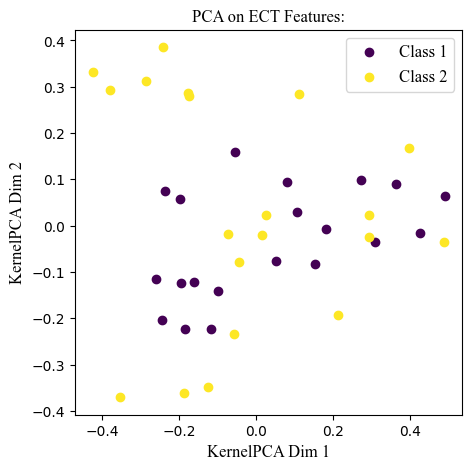

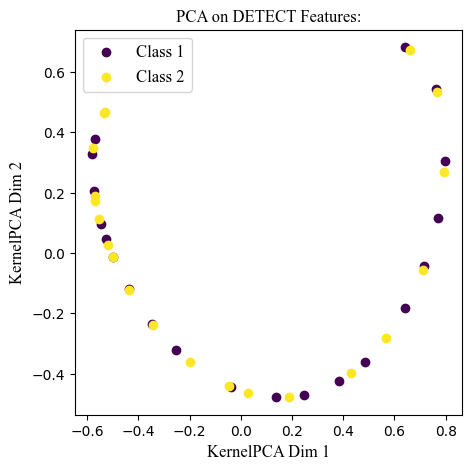

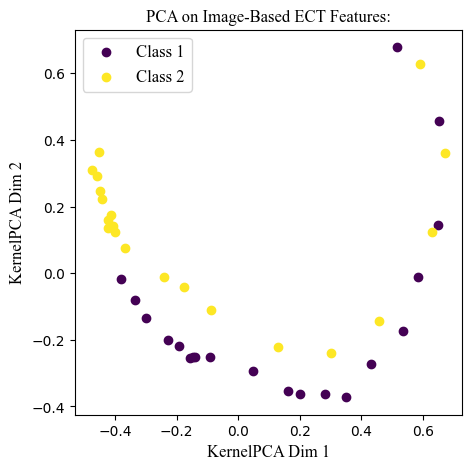

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
labels = np.array([0]*20 + [1]*20)
all_shapes = shapes_class1 + shapes_class2
detect_result = []
image_result = []
ect_result = []
random_result = []
# Example detection curves and images (for the first shape in each class)
for i, (points, simp_comp) in enumerate(all_shapes):
    ect_curve = detect.ect_2d(simp_comp, points, k=1000, interval=(-5., 1.), points=3000)
    detect_curve = detect.sect_2d(simp_comp, points, k=1000, interval=(-5., 5.), points=10000, mode='mean')
    x_values = np.linspace(-5., 5., 10000)
    # plt.figure()
    # plt.title(f"Detection Curve for Shape {i+1}")
    # plt.plot(x_values, detect_curve, label='DETECT Curve')
    # plt.show()
    ect_image = detect.EctImg(simp_comp, points, k=1000, xinterval=(-5., 1.), xpoints=3000, yinterval=(0., 4), ypoints=4, factor=1)
    # ect_image.plot()
    ectimage_result = ect_image.compute(simp_comp, points, k=1000, xinterval=(-5., 1.), xpoints=3000, yinterval=(0., 4), ypoints=4, factor=1 )
    ect_curve = np.array(ect_curve)
    ect_result.append(ect_curve.flatten())
    detect_result.append(detect_curve)
    image_result.append(ectimage_result.flatten())


ect_result = np.array(ect_result)
detect_result = np.array(detect_result)
image_result = np.array(image_result)
ect_for_tsne = ect_result.reshape(ect_result.shape[0], -1)
DETECT_for_tsne = detect_result.reshape(detect_result.shape[0], -1)
image_for_tsne = image_result.reshape(image_result.shape[0], -1)
def compute_l2_distance_matrix(X):
    """
    Compute the pairwise L2 distances between rows of X.
    X is shape (n_samples, n_features).

    Returns:
        dist_matrix : np.ndarray of shape (n_samples, n_samples)
    """
    # We can use a fast trick: ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x·y
    # or simply use cdist from scipy if you prefer clarity.
    # We'll do it with numpy broadcasting for demonstration.

    # sum_of_squares[i] = ||X_i||^2
    sum_of_squares = np.sum(X**2, axis=1, keepdims=True)  # shape (n,1)
    # Pairwise squared distances:
    # D_ij = sum_of_squares[i] + sum_of_squares[j] - 2 * X_i dot X_j
    # We'll compute the dot products first:
    dot_products = X @ X.T  # shape (n,n)

    sq_dists = sum_of_squares + sum_of_squares.T - 2*dot_products
    # L2 distances are sqrt of that:
    dist_matrix = np.sqrt(np.maximum(sq_dists, 0.0))  # numerical safety

    return dist_matrix

def construct_rbf_kernel_from_l2(dist_matrix, sigma=None):
    """
    Construct an RBF kernel from the pairwise L2 distance matrix.
    If sigma is not provided, the median of the distances is used.

    Parameters:
        dist_matrix : np.array, shape (n,n)
            The matrix of pairwise L2 distances.
        sigma : float or None
            The RBF kernel width parameter.

    Returns:
        kernel_matrix : np.array of shape (n,n)
    """
    if sigma is None:
        # Use the median of all pairwise distances as a heuristic
        sigma = np.median(dist_matrix)

    kernel_matrix = np.exp(- dist_matrix**2 / (2 * sigma**2))
    return kernel_matrix


def kernel_pca_plot(features, labels, title_prefix, sigma=None):
    """
    Given a feature matrix, compute the L2 distance-based RBF kernel,
    run KernelPCA in 2D, and plot.
    """
    # 1) Pairwise L2 distances
    dist_matrix = compute_l2_distance_matrix(features)
    # 2) RBF kernel
    kernel_matrix = construct_rbf_kernel_from_l2(dist_matrix, sigma=sigma)
    # 3) KernelPCA with 'precomputed' kernel
    kpca = KernelPCA(n_components=2, kernel='precomputed', random_state=42)
    embedding_2d = kpca.fit_transform(kernel_matrix)  # shape (n,2)

    # 4) Plot
    colors = plt.cm.viridis(np.linspace(0, 1, 2))
    class_color_map = {0: colors[0], 1: colors[1]}
    class_labels = {0: 'Class 1', 1: 'Class 2'}

    plt.figure(figsize=(5, 5))
    font_properties = {'family': 'Times New Roman', 'size': 12}

    for class_label, color in class_color_map.items():
        idx = np.where(labels == class_label)[0]
        x, y = embedding_2d[idx].T
        plt.scatter(x, y, label=class_labels[class_label], color=color, marker='o')

    plt.xlabel('KernelPCA Dim 1', fontdict=font_properties)
    plt.ylabel('KernelPCA Dim 2', fontdict=font_properties)
    plt.title(f'PCA on {title_prefix}:', fontdict=font_properties)
    plt.legend(loc='best', prop=font_properties)
    plt.show()

###############################################################################
# Now apply to each feature set
###############################################################################
kernel_pca_plot(ect_for_tsne,     labels, "ECT Features")
kernel_pca_plot(DETECT_for_tsne,  labels, "DETECT Features")
kernel_pca_plot(image_for_tsne,   labels, "Image-Based ECT Features")


### mdscale

In [4]:
shapes_class1 = generate_noisy_three_edges_shared_origin_with_rotation(n=100, k=20, noise_std=0.02, seed=1)
shapes_class2 = generate_noisy_three_edges_shared_origin_with_rotation(n=100, k=20, noise_std=0.02, seed=2)
all_shapes = shapes_class1 + shapes_class2  # total 40 shapes

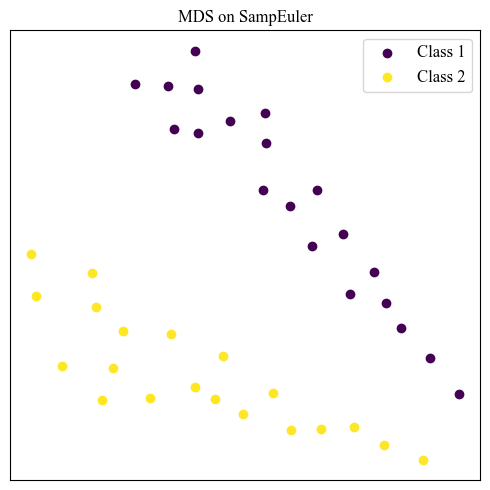

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS as mdscale
import matplotlib.pyplot as plt
import My_ECT as detect

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    return avg_cost_p ** (1.0 / p)

def compute_distance_matrix(measures, p=2, delta_x=1.0):
    n = len(measures)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = wasserstein_distance(measures[i], measures[j], p=p, delta_x=delta_x)
            D[i, j] = D[j, i] = d
    return D

random_ect_list = []  # We'll store each shape's Random ECT (k x N) as an element in this list

k_val = 1000      # same value you used for detect.RandomEct_2d
num_points = 3000 # same value you used for detect.RandomEct_2d

for i, (points, simp_comp) in enumerate(all_shapes):
    # The random ECT is a (k_val x num_points) array
    random_ect = detect.RandomEct_2d(simp_comp, points, k=k_val, interval=(-5., 1.), points=num_points)
    random_ect = np.array(random_ect)  # shape = (1000, 3000)
    random_ect_list.append(random_ect)
delta_x = 6.0 / (num_points - 1)  
distance_matrix = compute_distance_matrix(random_ect_list, p=2, delta_x=delta_x)

# ----- HERE: metric MDS (mdscale) directly on distances -----
mds = mdscale(
    n_components=2,
    dissimilarity='precomputed',
    random_state=42,
    metric=True         # True for metric MDS (classical)
)
mds_coords = mds.fit_transform(distance_matrix)  # shape = (n_shapes, 2)

# ----- Plot the 2D embedding -----
labels = np.array([0]*20 + [1]*20)  # adjust if you have different class sizes
colors = plt.cm.viridis(np.linspace(0, 1, 2))
class_color_map = {0: colors[0], 1: colors[1]}
class_labels = {0: 'Class 1', 1: 'Class 2'}

plt.figure(figsize=(5,5))
font_props = {'family': 'Times New Roman', 'size': 12}

for cls, col in class_color_map.items():
    idx = np.where(labels == cls)[0]
    x, y = mds_coords[idx].T
    plt.scatter(x, y, label=class_labels[cls], color=col, marker='o')


# plt.title('MDS on SampEuler', fontdict=font_props)
plt.legend(prop=font_props)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


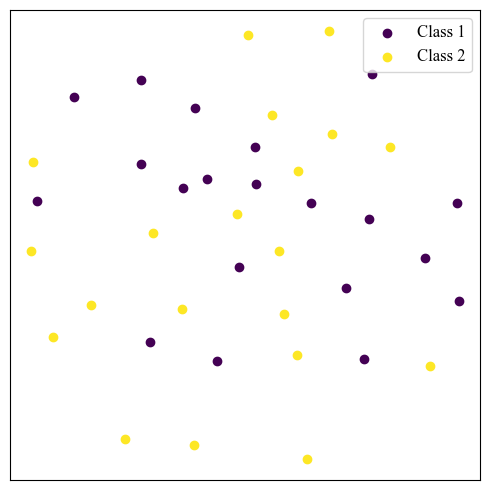

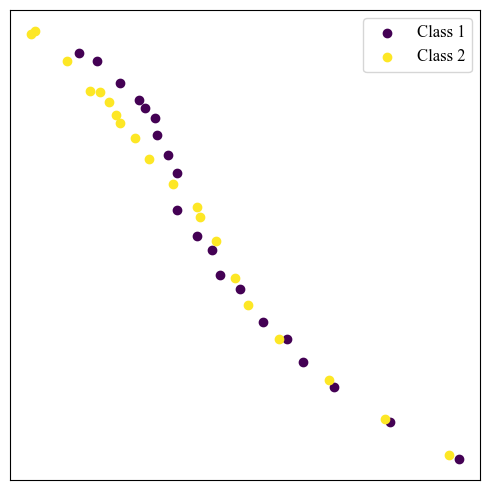

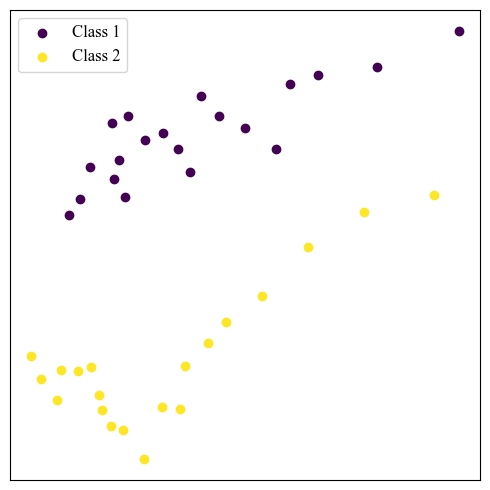

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS as mdscale

# — assume shapes_class1, shapes_class2, detect, generate… are already defined above —

labels = np.array([0]*20 + [1]*20)
all_shapes = shapes_class1 + shapes_class2

# 1) Compute your three feature matrices
ect_result, detect_result, image_result = [], [], []
for i, (points, simp_comp) in enumerate(all_shapes):
    # ECT curve
    ect_curve = detect.ect_2d(simp_comp, points, k=1000,
                              interval=(-5.,1.), points=3000)
    ect_result.append(np.array(ect_curve).flatten())

    # DETECT curve
    detect_curve = detect.sect_2d(simp_comp, points, k=1000,
                                  interval=(-5.,5.), points=10000,
                                  mode='mean')
    detect_result.append(detect_curve)

    # Image‐based ECT
    img = detect.EctImg(simp_comp, points, k=1000,
                        xinterval=(-5.,1.), xpoints=3000,
                        yinterval=(0.,4), ypoints=4, factor=1)
    image_result.append(img.compute(simp_comp, points,
                                    k=1000,
                                    xinterval=(-5.,1.),
                                    xpoints=3000,
                                    yinterval=(0.,4),
                                    ypoints=4,
                                    factor=1).flatten())

ect_for_mds     = np.vstack(ect_result)
detect_for_mds  = np.vstack(detect_result)
image_for_mds   = np.vstack(image_result)

# 2) Utility: compute L2 distance matrix
def compute_l2_distance_matrix(X):
    sum_sq = np.sum(X**2, axis=1, keepdims=True)
    dot = X @ X.T
    sq_dists = sum_sq + sum_sq.T - 2*dot
    return np.sqrt(np.maximum(sq_dists, 0.0))

# 3) A plotting helper using MDS (“mdscale”)
def mds_plot(features, labels, title_prefix):
    # 3a) distance matrix
    dist_matrix = compute_l2_distance_matrix(features)

    # 3b) classical MDS
    mds = mdscale(
        n_components=2,
        dissimilarity='precomputed',
        metric=True,
        random_state=42
    )
    coords = mds.fit_transform(dist_matrix)  # shape (n_samples, 2)

    # 3c) scatter plot
    colors = plt.cm.viridis(np.linspace(0, 1, 2))
    cmap = {0: colors[0], 1: colors[1]}
    labels_map = {0: 'Class 1', 1: 'Class 2'}

    plt.figure(figsize=(5,5))
    fp = {'family': 'Times New Roman', 'size': 12}

    for cls in [0,1]:
        idx = np.where(labels==cls)[0]
        x, y = coords[idx].T
        plt.scatter(x, y, label=labels_map[cls],
                    color=cmap[cls], marker='o')


    plt.legend(prop=fp)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# 4) Run MDS‐based embedding & plot for each feature set
mds_plot(ect_for_mds,    labels, "ECT Features")
mds_plot(detect_for_mds, labels, "DETECT Features")
mds_plot(image_for_mds,  labels, "EulerImage Features")


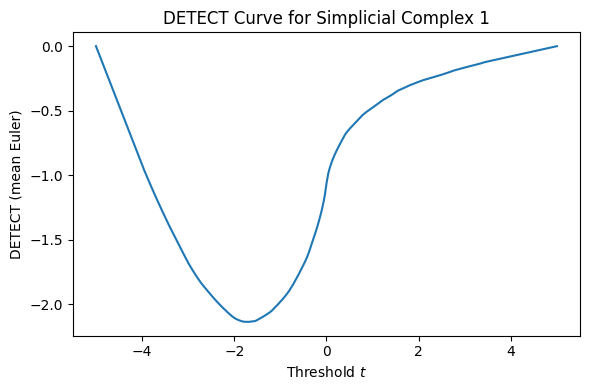

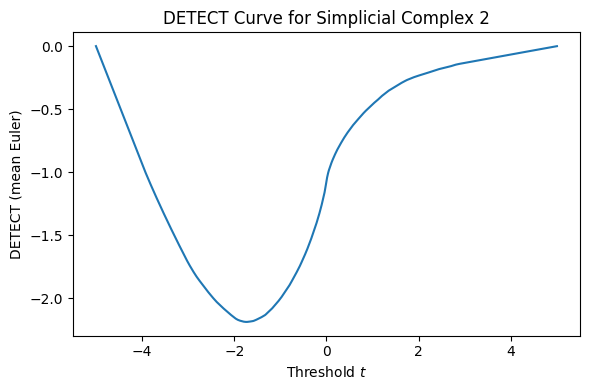

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assume detect_result and labels are already in the environment
# For demonstration, we simulate some data here:
# Remove these two lines if detect_result and labels are defined
# detect_result = [np.sin(np.linspace(-5, 5, 1000)) + np.random.randn(1000)*0.1 for _ in range(40)]
# labels = np.array([0]*20 + [1]*20)

# 1) Pick one index from each class
idx_class0 = np.where(labels == 0)[0][0]   # first shape of class 0
idx_class1 = np.where(labels == 1)[0][0]   # first shape of class 1

curve0 = detect_result[idx_class0]
curve1 = detect_result[idx_class1]

# 2) Reconstruct threshold axis
t0, t1 = -5.0, 5.0
t = np.linspace(t0, t1, curve0.shape[0])

# 3) Separate plots
# Class 0
plt.figure(figsize=(6, 4))
plt.plot(t, curve0)
plt.xlabel('Threshold $t$')
plt.ylabel('DETECT (mean Euler)')
plt.title(f'DETECT Curve for Simplicial Complex 1')
plt.tight_layout()
plt.show()

# Class 1
plt.figure(figsize=(6, 4))
plt.plot(t, curve1)
plt.xlabel('Threshold $t$')
plt.ylabel('DETECT (mean Euler)')
plt.title(f'DETECT Curve for Simplicial Complex 2')
plt.tight_layout()
plt.show()


### lda

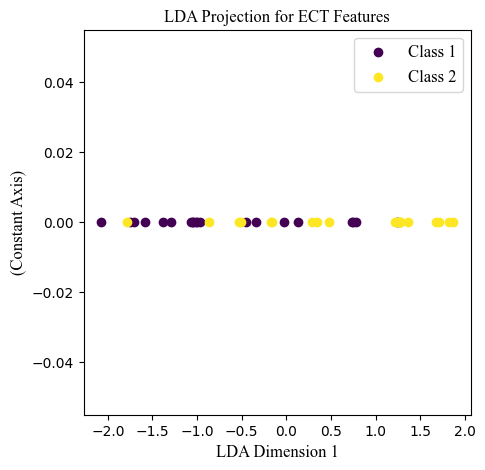

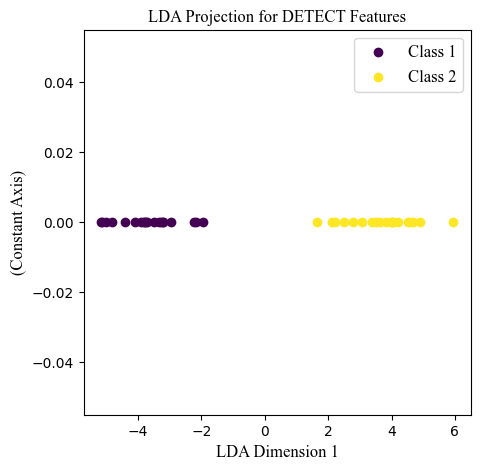

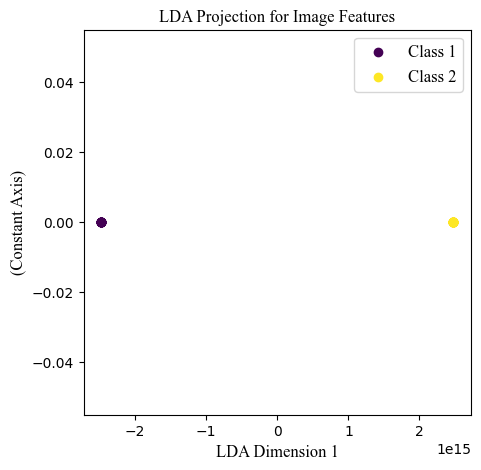

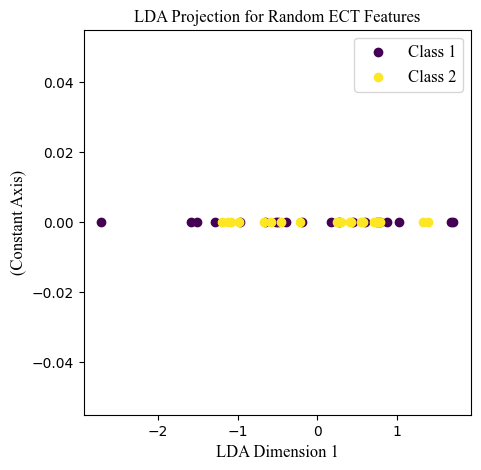

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

###############################################################################
# Step 1: Prepare the data (already done in your snippet)
###############################################################################
# shapes_class1 -> 20 shapes
# shapes_class2 -> 20 shapes
# all_shapes = shapes_class1 + shapes_class2 -> 40 shapes total
# ect_for_tsne, DETECT_for_tsne, image_for_tsne, random_for_tsne
#   have shape (40, feature_dimension) after reshaping.

###############################################################################
# Step 2: Define the labels
###############################################################################
# Because you have 20 shapes in class1 and 20 shapes in class2:
labels = np.array([0]*20 + [1]*20)  

###############################################################################
# Step 3: Apply LDA
###############################################################################
# Initialize LDA (max 1 dimension for 2 classes)
lda_ect = LDA(n_components=1)
lda_detect = LDA(n_components=1)
lda_image = LDA(n_components=1)
lda_random = LDA(n_components=1)

# Fit-transform each feature set
lda_ect_result_1d = lda_ect.fit_transform(ect_for_tsne, labels)
lda_detect_result_1d = lda_detect.fit_transform(DETECT_for_tsne, labels)
lda_image_result_1d = lda_image.fit_transform(image_for_tsne, labels)
lda_random_result_1d = lda_random.fit_transform(random_for_tsne, labels)

# LDA with two classes yields only 1 dimension. For a "2D plot," add zeros as the second dimension.
lda_ect_result_2d    = np.column_stack([lda_ect_result_1d,    np.zeros_like(lda_ect_result_1d)])
lda_detect_result_2d = np.column_stack([lda_detect_result_1d, np.zeros_like(lda_detect_result_1d)])
lda_image_result_2d  = np.column_stack([lda_image_result_1d,  np.zeros_like(lda_image_result_1d)])
lda_random_result_2d = np.column_stack([lda_random_result_1d, np.zeros_like(lda_random_result_1d)])

###############################################################################
# Step 4: Define a plotting function for the single LDA axis in a 2D plot
###############################################################################
colors = plt.cm.viridis(np.linspace(0, 1, 2))
class_color_map = {0: colors[0], 1: colors[1]}
class_labels = {0: 'Class 1', 1: 'Class 2'}

def plot_lda(lda_result_2d, title):
    """
    Plots the single LDA dimension as a line on a 2D scatter plot.
    """
    plt.figure(figsize=(5, 5))
    font_properties = {'family': 'Times New Roman', 'size': 12}
    
    for class_label, color in class_color_map.items():
        indices = np.where(labels == class_label)[0]
        x, y = lda_result_2d[indices].T
        plt.scatter(x, y, label=class_labels[class_label], color=color, marker='o')
    
    plt.xlabel('LDA Dimension 1', fontdict=font_properties)
    plt.ylabel('(Constant Axis)', fontdict=font_properties)
    plt.title(title, fontdict=font_properties)
    plt.legend(loc='best', prop=font_properties)
    plt.show()

###############################################################################
# Step 5: Plot the LDA results
###############################################################################
plot_lda(lda_ect_result_2d,    'LDA Projection for ECT Features')
plot_lda(lda_detect_result_2d, 'LDA Projection for DETECT Features')
plot_lda(lda_image_result_2d,  'LDA Projection for Image Features')
plot_lda(lda_random_result_2d, 'LDA Projection for Random ECT Features')


### pca

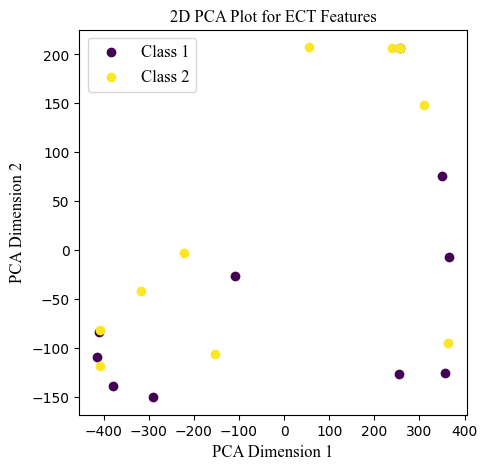

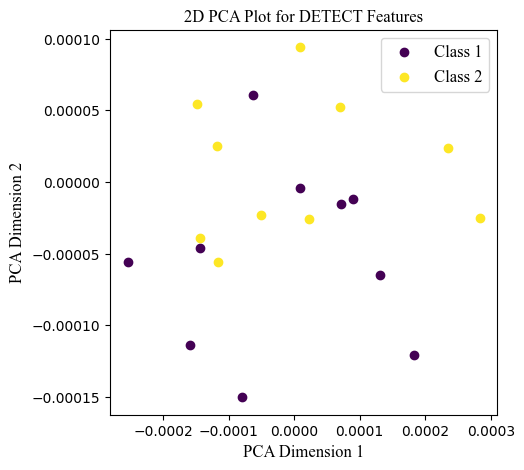

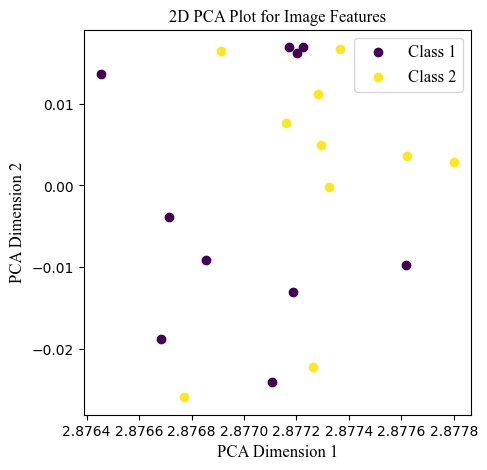

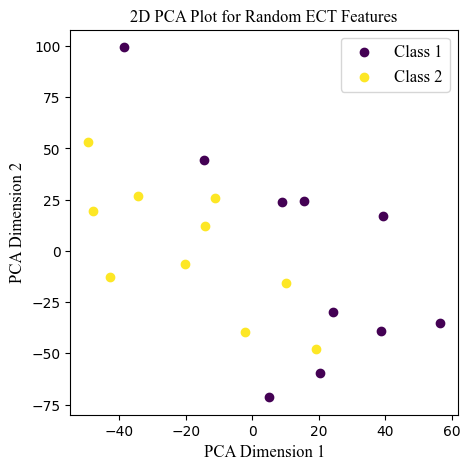

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Generate the PCA results for each feature set
pca_ect = PCA(n_components=2)
pca_ect_result = pca_ect.fit_transform(ect_for_tsne)

pca_detect = PCA(n_components=2)
pca_detect_result = pca_detect.fit_transform(DETECT_for_tsne)

pca_image = PCA(n_components=2)
pca_image_result = pca_image.fit_transform(image_for_tsne)

pca_random = PCA(n_components=2)
pca_random_result = pca_random.fit_transform(random_for_tsne)

# Create labels for the shape classes
labels = np.array([0] * 10 + [1] * 10)  # 0 for class 1, 1 for class 2

# Define a color map for the shape classes
colors = plt.cm.viridis(np.linspace(0, 1, 2))
class_color_map = {0: colors[0], 1: colors[1]}
class_labels = {0: 'Class 1', 1: 'Class 2'}

def plot_pca(pca_result, title):
    plt.figure(figsize=(5, 5))
    font_properties = {'family': 'Times New Roman', 'size': 12}

    for class_label, color in class_color_map.items():
        indices = np.where(labels == class_label)[0]
        x, y = pca_result[indices].T
        plt.scatter(x, y, label=class_labels[class_label], color=color, marker='o')

    plt.xlabel('PCA Dimension 1', fontdict=font_properties)
    plt.ylabel('PCA Dimension 2', fontdict=font_properties)
    plt.title(title, fontdict=font_properties)
    plt.legend(loc='best', prop=font_properties)
    plt.show()

# Plot the PCA projections
plot_pca(pca_ect_result, '2D PCA Plot for ECT Features')
plot_pca(pca_detect_result, '2D PCA Plot for DETECT Features')
plot_pca(pca_image_result, '2D PCA Plot for Image Features')
plot_pca(pca_random_result, '2D PCA Plot for Random ECT Features')


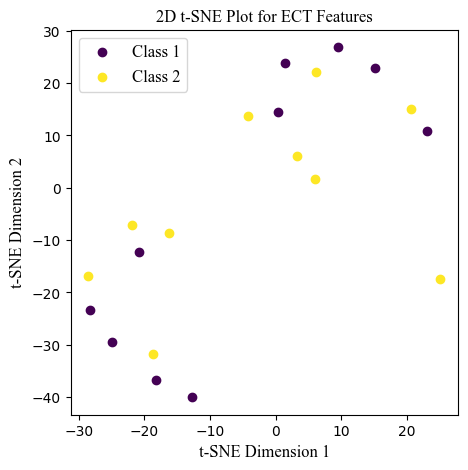

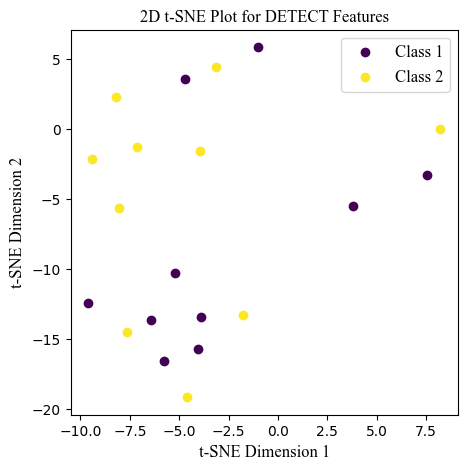

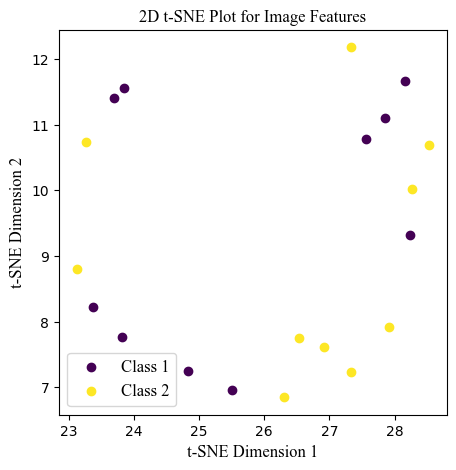

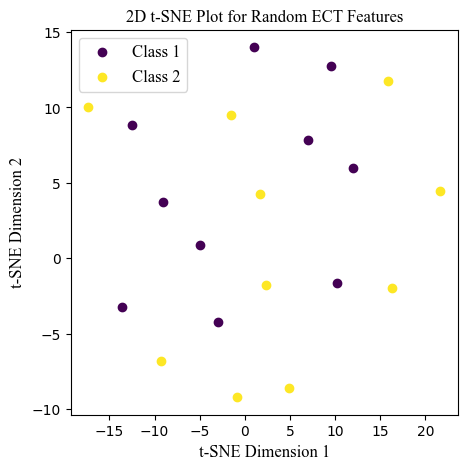

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Generate the t-SNE results for DETECT_for_tsne and image_for_tsne
tsne_ect = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_ect_result = tsne_ect.fit_transform(ect_for_tsne)

tsne_detect = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_detect_result = tsne_detect.fit_transform(DETECT_for_tsne)

tsne_image = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_image_result = tsne_image.fit_transform(image_for_tsne)
tsne_random = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_random_result = tsne_random.fit_transform(random_for_tsne)

# Create labels for the shape classes
labels = np.array([0] * 10 + [1] * 10)  # 0 for class 1, 1 for class 2

# Define a color map for the shape classes
colors = plt.cm.viridis(np.linspace(0, 1, 2))
class_color_map = {0: colors[0], 1: colors[1]}
class_labels = {0: 'Class 1', 1: 'Class 2'}

def plot_tsne(tsne_result, title):
    plt.figure(figsize=(5, 5))
    font_properties = {'family': 'Times New Roman', 'size': 12}

    for class_label, color in class_color_map.items():
        indices = np.where(labels == class_label)[0]
        x, y = tsne_result[indices].T
        plt.scatter(x, y, label=class_labels[class_label], color=color, marker='o')

    plt.xlabel('t-SNE Dimension 1', fontdict=font_properties)
    plt.ylabel('t-SNE Dimension 2', fontdict=font_properties)
    plt.title(title, fontdict=font_properties)
    plt.legend(loc='best', prop=font_properties)
    plt.show()

plot_tsne(tsne_ect_result, '2D t-SNE Plot for ECT Features')

plot_tsne(tsne_detect_result, '2D t-SNE Plot for DETECT Features')

plot_tsne(tsne_image_result, '2D t-SNE Plot for Image Features')
plot_tsne(tsne_random_result, '2D t-SNE Plot for Random ECT Features')


## aligned shapes

In [14]:
import numpy as np
import math

def generate_noisy_three_edges_shared_origin_no_rotation(n, k, noise_std=0.01, seed=None):
    """
    Generates a shape consisting of three edges of lengths 2, 3, and 4,
    all emanating from a shared origin (0, 0). Each edge is discretized
    into 'n' points. Adds Gaussian noise (without any rotation) k times,
    returning a list of (points, simplices) pairs.

    :param n: Number of points on each edge, including the origin. Hence each edge 
              will have 'n' total points, with the origin being common to all edges.
    :param k: Number of noisy versions to generate.
    :param noise_std: Standard deviation of the added Gaussian noise (zero-mean).
    :param seed: Seed for the random number generator.
    :return: A list of length 'k', where each entry is (points, simplices).
    """
    if seed is not None:
        np.random.seed(seed)

    # Edge lengths
    edge_lengths = [2.0, 3.0, 4.0]

    # Generate 3 random angles in [0, 2π)
    edge_angles = np.random.uniform(0, 2 * math.pi, size=3)

    # Build base points
    base_points = []
    base_points.append([0.0, 0.0])  # origin

    # For each edge, generate (n - 1) additional points from the origin to the edge length in a specific direction.
    for length, theta in zip(edge_lengths, edge_angles):
        for j in range(1, n):
            fraction = j / (n - 1)
            t = length * fraction
            x = t * math.cos(theta)
            y = t * math.sin(theta)
            base_points.append([x, y])

    base_points = np.array(base_points, dtype=float)

    # Build simplices
    num_vertices = 1 + 3 * (n - 1)  # 1 (origin) + 3 edges * (n-1) new points
    simplices_template = []

    # 0-simplices (vertices)
    for i in range(num_vertices):
        simplices_template.append([i])

    # 1-simplices (edges): for each edge, connect origin -> first point and consecutive points.
    for edge_i in range(3):
        start = 1 + edge_i * (n - 1)
        simplices_template.append([0, start])  # edge from origin to first point on the edge
        for v in range(start, start + (n - 2)):
            simplices_template.append([v, v + 1])

    results = []
    for _ in range(k):
        # Start with an unrotated copy of the base points.
        current_points = base_points.copy()

        # Add Gaussian noise, ensuring the origin remains fixed.
        noise = np.random.normal(0.0, noise_std, current_points.shape)
        noise[0, :] = 0.0  # fix the origin (first point)
        current_points += noise

        # Append the noisy points with a copy of the simplices template
        points_copy = current_points.copy()
        simplices_copy = [s[:] for s in simplices_template]
        results.append((points_copy, simplices_copy))

    return results

# For plotting the resulting complexes using matplotlib:
import matplotlib.pyplot as plt

def plot_simplicial_complexes(results):
    """
    Plots each simplicial complex in the results list on its own figure,
    with fixed axis limits (-5 to 5) for both x and y axes.

    :param results: A list of (points, simplices) tuples.
    """
    for i, (points, simp_comp) in enumerate(results):
        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Plot the vertices
        ax.scatter(points[:, 0], points[:, 1], color='black', s=1)
        
        # Plot the edges (1-simplices)
        for simplex in simp_comp:
            simplex_points = points[simplex, :]
            if len(simplex) > 1:
                ax.plot(simplex_points[:, 0], simplex_points[:, 1], 'k-')
        
        # Fix the axis limits so every plot shows the region from -5 to 5
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_aspect('equal')

        ax.set_title(f"Simplicial Complex {(i + 1)%20}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        plt.show()


### pca

In [58]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    """
    Compute the Wasserstein distance between two empirical measures,
    each represented as a k x N array (each row is a function sampled at N points),
    incorporating the delta_x factor for uniformly sampled points.

    Parameters:
        empirical1 : np.array of shape (k, N)
            The first set of functions.
        empirical2 : np.array of shape (k, N)
            The second set of functions.
        p : float, default 2
            The order of the norm (p=2 for L2, p=1 for L1).
        delta_x : float, default 1.0
            The spacing between sample points, e.g.,
            (x_max - x_min) / (N - 1).

    Returns:
        float
            The computed Wasserstein distance.
    """
    # Compute the cost matrix using the Minkowski metric.
    # cdist returns (sum_i |f_i - g_i|^p)^(1/p), so we multiply by (delta_x)^(1/p)
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    
    # Solve the assignment problem to obtain the best matching.
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Compute the average p-th power cost for the matched pairs.
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    
    # Return the p-th root of the average cost.
    return avg_cost_p ** (1.0 / p)

def compute_distance_matrix(measures, p=2, delta_x=1.0):
    """
    Given a list 'measures' of empirical measures (each a k x N array),
    compute the pairwise Wasserstein distance matrix.

    Parameters:
        measures : list of np.array
            Each element is an empirical measure (k functions sampled at N points).
        p : float, default 2
            The order of the norm.
        delta_x : float, default 1.0
            The spacing between the sample points.

    Returns:
        np.array
            An n x n symmetric matrix of Wasserstein distances.
    """
    n = len(measures)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = wasserstein_distance(measures[i], measures[j], p=p, delta_x=delta_x)
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    return distance_matrix

def construct_rbf_kernel(distance_matrix, sigma=None):
    """
    Construct an RBF kernel from the distance matrix.
    If sigma is not provided, the median of the distances is used.

    Parameters:
        distance_matrix : np.array
            The matrix of pairwise Wasserstein distances.
        sigma : float or None, default None
            The RBF kernel width parameter.

    Returns:
        np.array
            The RBF kernel matrix.
    """
    if sigma is None:
        sigma = np.median(distance_matrix)
    kernel_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))
    return kernel_matrix


import numpy as np
import matplotlib.pyplot as plt

# 1) Import the kernel-related utilities you provided
# (Assuming they are already defined or imported from your code):
#   - wasserstein_distance
#   - compute_distance_matrix
#   - construct_rbf_kernel
# from your_file import wasserstein_distance, compute_distance_matrix, construct_rbf_kernel

# 2) Import KernelPCA for the "precomputed" kernel approach
from sklearn.decomposition import KernelPCA

###############################################################################
# 1) Generate data & compute Random ECT in (k x N) form
###############################################################################

shapes_class1 = generate_noisy_three_edges_shared_origin_no_rotation(n=100, k=20, noise_std=0.005, seed=1)
shapes_class2 = generate_noisy_three_edges_shared_origin_no_rotation(n=100, k=20, noise_std=0.005, seed=2)
all_shapes = shapes_class1 + shapes_class2  # total 40 shapes
random_ect_list = []  # We'll store each shape's Random ECT (k x N) as an element in this list

k_val = 1000      # same value you used for detect.RandomEct_2d
num_points = 3000 # same value you used for detect.RandomEct_2d

for i, (points, simp_comp) in enumerate(all_shapes):
    # The random ECT is a (k_val x num_points) array
    random_ect = detect.RandomEct_2d(simp_comp, points, k=k_val, interval=(-5., 1.), points=num_points)
    random_ect = np.array(random_ect)  # shape = (1000, 3000)
    random_ect_list.append(random_ect)


###############################################################################
# 2) Compute the Wasserstein-based RBF kernel
###############################################################################
# We first compute a distance matrix based on your "wasserstein_distance".
# Then we convert that distance matrix into an RBF kernel.

# Because you are sampling from x in [-5, 1] => total range = 6.0
# If you have 3000 sample points, delta_x ~ 6.0 / (3000 - 1).
delta_x = 6.0 / (num_points - 1)

# 2a) Pairwise Wasserstein distances
distance_matrix = compute_distance_matrix(random_ect_list, p=2, delta_x=delta_x)
# shape of distance_matrix => (40, 40) if you have 40 shapes total

# 2b) Construct RBF kernel from the distance matrix
# If sigma=None, it uses np.median(distance_matrix) by default
kernel_matrix = construct_rbf_kernel(distance_matrix, sigma=None)
# shape => (40, 40)

###############################################################################
# 3) KernelPCA in "precomputed" mode
###############################################################################
# Instead of using normal PCA on raw features, we pass the kernel matrix to KernelPCA.
# n_components=2 => reduce to 2D.

kpca = KernelPCA(n_components=2, kernel='precomputed')
kpca_random_2d = kpca.fit_transform(kernel_matrix)  
# shape => (40, 2)

###############################################################################
# 4) Plot the 2D KernelPCA result
###############################################################################
# Label array: 20 from shapes_class1 (label=0), 20 from shapes_class2 (label=1)
labels = np.array([0]*20 + [1]*20)

# Prepare a color map
colors = plt.cm.viridis(np.linspace(0, 1, 2))
class_color_map = {0: colors[0], 1: colors[1]}
class_labels = {0: 'Class 1', 1: 'Class 2'}

plt.figure(figsize=(5,5))
font_properties = {'family': 'Times New Roman', 'size': 12}

for class_label, color in class_color_map.items():
    idx = np.where(labels == class_label)[0]
    x, y = kpca_random_2d[idx].T
    plt.scatter(x, y, label=class_labels[class_label], color=color, marker='o')

plt.xlabel('PCA Dim 1', fontdict=font_properties)
plt.ylabel('PCA Dim 2', fontdict=font_properties)
plt.title('PCA on Random ECT', fontdict=font_properties)
plt.legend(prop=font_properties)
plt.show()


KeyboardInterrupt: 

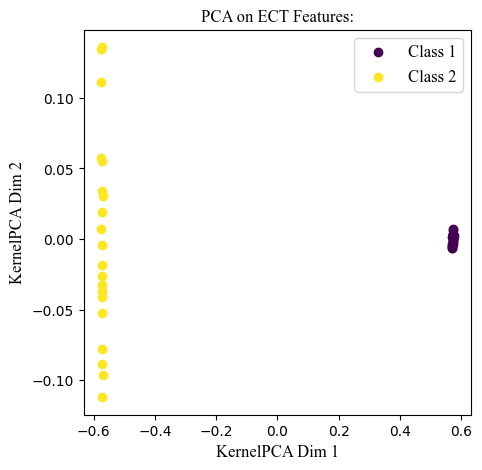

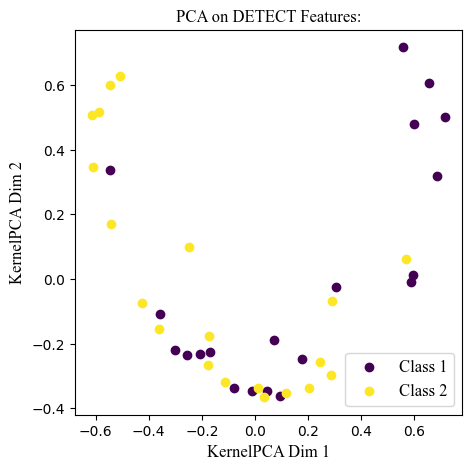

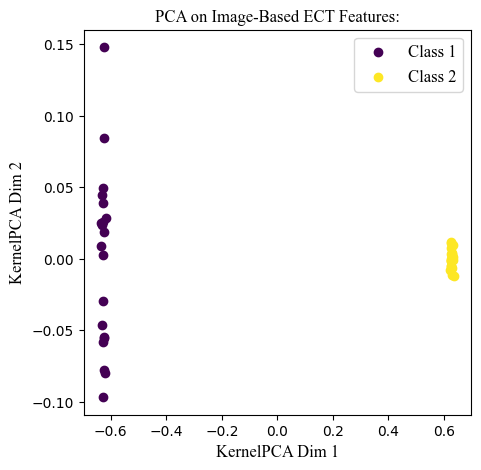

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
labels = np.array([0]*20 + [1]*20)
detect_result = []
image_result = []
ect_result = []
random_result = []
# Example detection curves and images (for the first shape in each class)
for i, (points, simp_comp) in enumerate(all_shapes):
    ect_curve = detect.ect_2d(simp_comp, points, k=1000, interval=(-5., 1.), points=3000)
    detect_curve = detect.sect_2d(simp_comp, points, k=1000, interval=(-5., 5.), points=10000, mode='mean')
    x_values = np.linspace(-5., 5., 10000)
    # plt.figure()
    # plt.title(f"Detection Curve for Shape {i+1}")
    # plt.plot(x_values, detect_curve, label='DETECT Curve')
    # plt.show()
    ect_image = detect.EctImg(simp_comp, points, k=1000, xinterval=(-5., 1.), xpoints=3000, yinterval=(0., 4), ypoints=4, factor=1)
    # ect_image.plot()
    ectimage_result = ect_image.compute(simp_comp, points, k=1000, xinterval=(-5., 1.), xpoints=3000, yinterval=(0., 4), ypoints=4, factor=1 )
    ect_curve = np.array(ect_curve)
    ect_result.append(ect_curve.flatten())
    detect_result.append(detect_curve)
    image_result.append(ectimage_result.flatten())


ect_result = np.array(ect_result)
detect_result = np.array(detect_result)
image_result = np.array(image_result)
ect_for_tsne = ect_result.reshape(ect_result.shape[0], -1)
DETECT_for_tsne = detect_result.reshape(detect_result.shape[0], -1)
image_for_tsne = image_result.reshape(image_result.shape[0], -1)
def compute_l2_distance_matrix(X):
    """
    Compute the pairwise L2 distances between rows of X.
    X is shape (n_samples, n_features).

    Returns:
        dist_matrix : np.ndarray of shape (n_samples, n_samples)
    """
    # We can use a fast trick: ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x·y
    # or simply use cdist from scipy if you prefer clarity.
    # We'll do it with numpy broadcasting for demonstration.

    # sum_of_squares[i] = ||X_i||^2
    sum_of_squares = np.sum(X**2, axis=1, keepdims=True)  # shape (n,1)
    # Pairwise squared distances:
    # D_ij = sum_of_squares[i] + sum_of_squares[j] - 2 * X_i dot X_j
    # We'll compute the dot products first:
    dot_products = X @ X.T  # shape (n,n)

    sq_dists = sum_of_squares + sum_of_squares.T - 2*dot_products
    # L2 distances are sqrt of that:
    dist_matrix = np.sqrt(np.maximum(sq_dists, 0.0))  # numerical safety

    return dist_matrix

def construct_rbf_kernel_from_l2(dist_matrix, sigma=None):
    """
    Construct an RBF kernel from the pairwise L2 distance matrix.
    If sigma is not provided, the median of the distances is used.

    Parameters:
        dist_matrix : np.array, shape (n,n)
            The matrix of pairwise L2 distances.
        sigma : float or None
            The RBF kernel width parameter.

    Returns:
        kernel_matrix : np.array of shape (n,n)
    """
    if sigma is None:
        # Use the median of all pairwise distances as a heuristic
        sigma = np.median(dist_matrix)

    kernel_matrix = np.exp(- dist_matrix**2 / (2 * sigma**2))
    return kernel_matrix


def kernel_pca_plot(features, labels, title_prefix, sigma=None):
    """
    Given a feature matrix, compute the L2 distance-based RBF kernel,
    run KernelPCA in 2D, and plot.
    """
    # 1) Pairwise L2 distances
    dist_matrix = compute_l2_distance_matrix(features)
    # 2) RBF kernel
    kernel_matrix = construct_rbf_kernel_from_l2(dist_matrix, sigma=sigma)
    # 3) KernelPCA with 'precomputed' kernel
    kpca = KernelPCA(n_components=2, kernel='precomputed', random_state=42)
    embedding_2d = kpca.fit_transform(kernel_matrix)  # shape (n,2)

    # 4) Plot
    colors = plt.cm.viridis(np.linspace(0, 1, 2))
    class_color_map = {0: colors[0], 1: colors[1]}
    class_labels = {0: 'Class 1', 1: 'Class 2'}

    plt.figure(figsize=(5, 5))
    font_properties = {'family': 'Times New Roman', 'size': 12}

    for class_label, color in class_color_map.items():
        idx = np.where(labels == class_label)[0]
        x, y = embedding_2d[idx].T
        plt.scatter(x, y, label=class_labels[class_label], color=color, marker='o')

    plt.xlabel('KernelPCA Dim 1', fontdict=font_properties)
    plt.ylabel('KernelPCA Dim 2', fontdict=font_properties)
    plt.title(f'PCA on {title_prefix}:', fontdict=font_properties)
    plt.legend(loc='best', prop=font_properties)
    plt.show()

###############################################################################
# Now apply to each feature set
###############################################################################
kernel_pca_plot(ect_for_tsne,     labels, "ECT Features")
kernel_pca_plot(DETECT_for_tsne,  labels, "DETECT Features")
kernel_pca_plot(image_for_tsne,   labels, "Image-Based ECT Features")


### mdscale


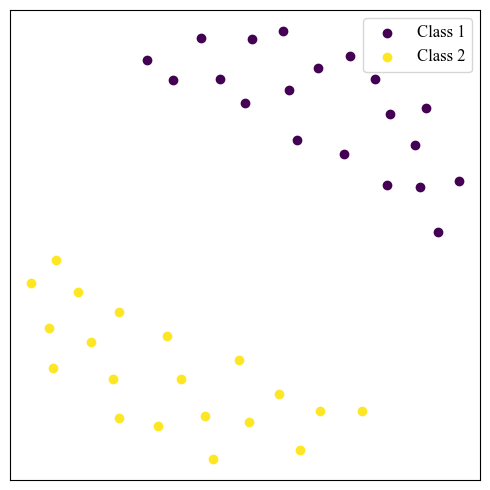

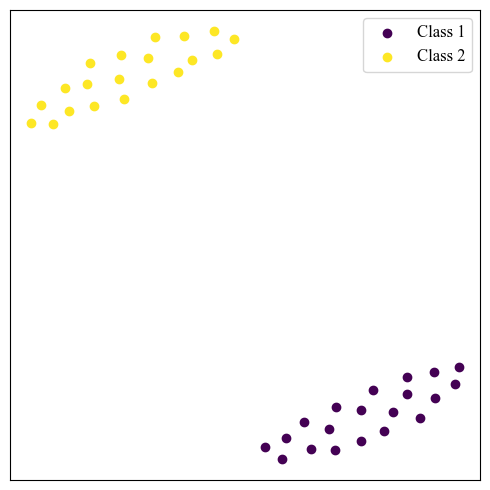

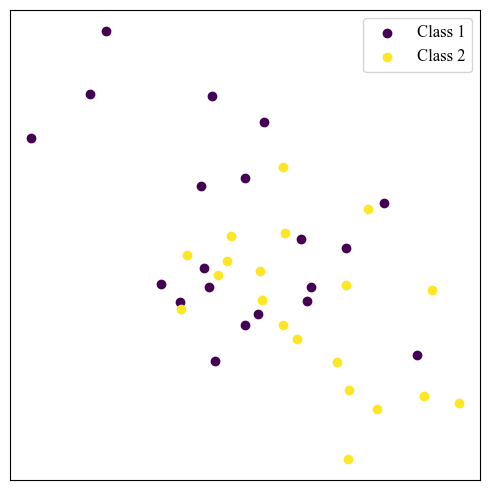

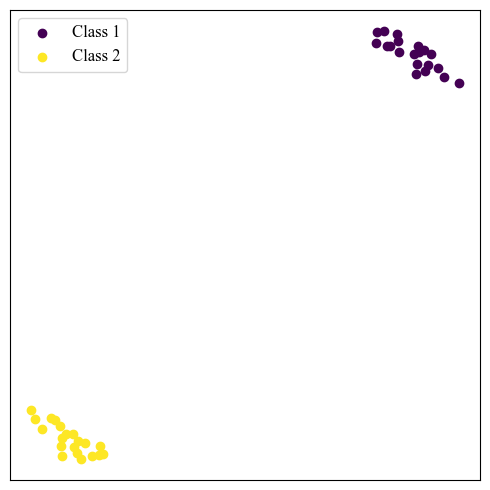

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS as mdscale

# -----------------------------------------------------------------------------
# 1) Wasserstein distance & MDS on Random ECT
# -----------------------------------------------------------------------------

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) \
                  * (delta_x ** (1.0 / p))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    return avg_cost_p ** (1.0 / p)

def compute_distance_matrix(measures, p=2, delta_x=1.0):
    n = len(measures)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = wasserstein_distance(measures[i], measures[j],
                                     p=p, delta_x=delta_x)
            D[i, j] = D[j, i] = d
    return D

# -- generate your data as before --
shapes_class1 = generate_noisy_three_edges_shared_origin_no_rotation(
    n=100, k=20, noise_std=0.005, seed=1)
shapes_class2 = generate_noisy_three_edges_shared_origin_no_rotation(
    n=100, k=20, noise_std=0.005, seed=2)
all_shapes = shapes_class1 + shapes_class2

# compute list of Random ECT arrays
random_ect_list = []
k_val, num_points = 1000, 3000
for points, simp_comp in all_shapes:
    re = detect.RandomEct_2d(simp_comp, points,
                             k=k_val,
                             interval=(-5.,1.),
                             points=num_points)
    random_ect_list.append(np.array(re))

# pairwise Wasserstein distances
delta_x = 6.0 / (num_points - 1)
W = compute_distance_matrix(random_ect_list,
                            p=2,
                            delta_x=delta_x)

# classical MDS on Wasserstein distances
mds_w = mdscale(
    n_components=2,
    dissimilarity='precomputed',
    metric=True,
    random_state=42
)
coords_w = mds_w.fit_transform(W)

# plot Random ECT embedding
labels = np.array([0]*20 + [1]*20)
colors = plt.cm.viridis(np.linspace(0,1,2))
cmap = {0: colors[0], 1: colors[1]}
lbls = {0:'Class 1', 1:'Class 2'}

plt.figure(figsize=(5,5))
fp = {'family':'Times New Roman','size':12}
for cls in [0,1]:
    idx = np.where(labels==cls)[0]
    x,y = coords_w[idx].T
    plt.scatter(x, y, label=lbls[cls], color=cmap[cls], marker='o')
plt.xticks([])
plt.yticks([])
plt.legend(prop=fp)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 2) L2‐features & MDS on DETECT / ECT‐2d / Image‐ECT
# -----------------------------------------------------------------------------

# collect features
ect_res, detect_res, img_res = [], [], []
for points, simp_comp in all_shapes:
    # ECT curve
    ec = detect.ect_2d(simp_comp, points,
                      k=1000, interval=(-5.,1.), points=3000)
    ect_res.append(np.array(ec).flatten())

    # DETECT curve
    dc = detect.sect_2d(simp_comp, points,
                       k=1000, interval=(-5.,5.),
                       points=10000, mode='mean')
    detect_res.append(dc)

    # Image-based ECT
    im = detect.EctImg(simp_comp, points,
                       k=1000,
                       xinterval=(-5.,1.), xpoints=3000,
                       yinterval=(0.,4), ypoints=4,
                       factor=1)
    img_res.append(im.compute(simp_comp, points,
                              k=1000,
                              xinterval=(-5.,1.),
                              xpoints=3000,
                              yinterval=(0.,4),
                              ypoints=4,
                              factor=1).flatten())

X_ect    = np.vstack(ect_res)
X_detect = np.vstack(detect_res)
X_image  = np.vstack(img_res)

def compute_l2_distance_matrix(X):
    ss = np.sum(X**2, axis=1, keepdims=True)
    DP = X @ X.T
    sq = ss + ss.T - 2*DP
    return np.sqrt(np.maximum(sq, 0.0))

def mds_plot(X, labels, title):
    D = compute_l2_distance_matrix(X)
    mds = mdscale(n_components=2,
                  dissimilarity='precomputed',
                  metric=True,
                  random_state=42)
    C = mds.fit_transform(D)

    plt.figure(figsize=(5,5))
    fp = {'family':'Times New Roman','size':12}
    for cls in [0,1]:
        idx = np.where(labels==cls)[0]
        x,y = C[idx].T
        plt.scatter(x, y, label=lbls[cls], color=cmap[cls], marker='o')
    plt.xticks([])
    plt.yticks([])
    plt.legend(prop=fp)
    plt.tight_layout()
    plt.show()

# plot all three
mds_plot(X_ect,    labels, "ECT Features")
mds_plot(X_detect, labels, "DETECT Features")
mds_plot(X_image,  labels, "EulerImage ECT Features")


## thymus image example

In [1]:
import os
from PIL import Image
import sys
import numpy as np
sys.path.append('eucalc_directory')
import eucalc as ec
datafolder = "Old_Young_Comparison"
name = "O1_K8._5.tif"
file_path = os.path.join(datafolder, name)
with Image.open(file_path) as img:
    img_array = np.array(img)




In [12]:
cplx = ec.EmbeddedComplex(img_array)
cplx.preproc_ect()
ect = np.empty((1, 2000), dtype=float)
thetas = np.linspace(0, 2 * np.pi, 1000 + 1)
theta = thetas[0]
direction = np.array((np.sin(theta), np.cos(theta)))
ect_dir = cplx.compute_euler_characteristic_transform(direction)
T = np.linspace(-1, 1, 2000)
ect[0] = [ect_dir.evaluate(t) for t in T]

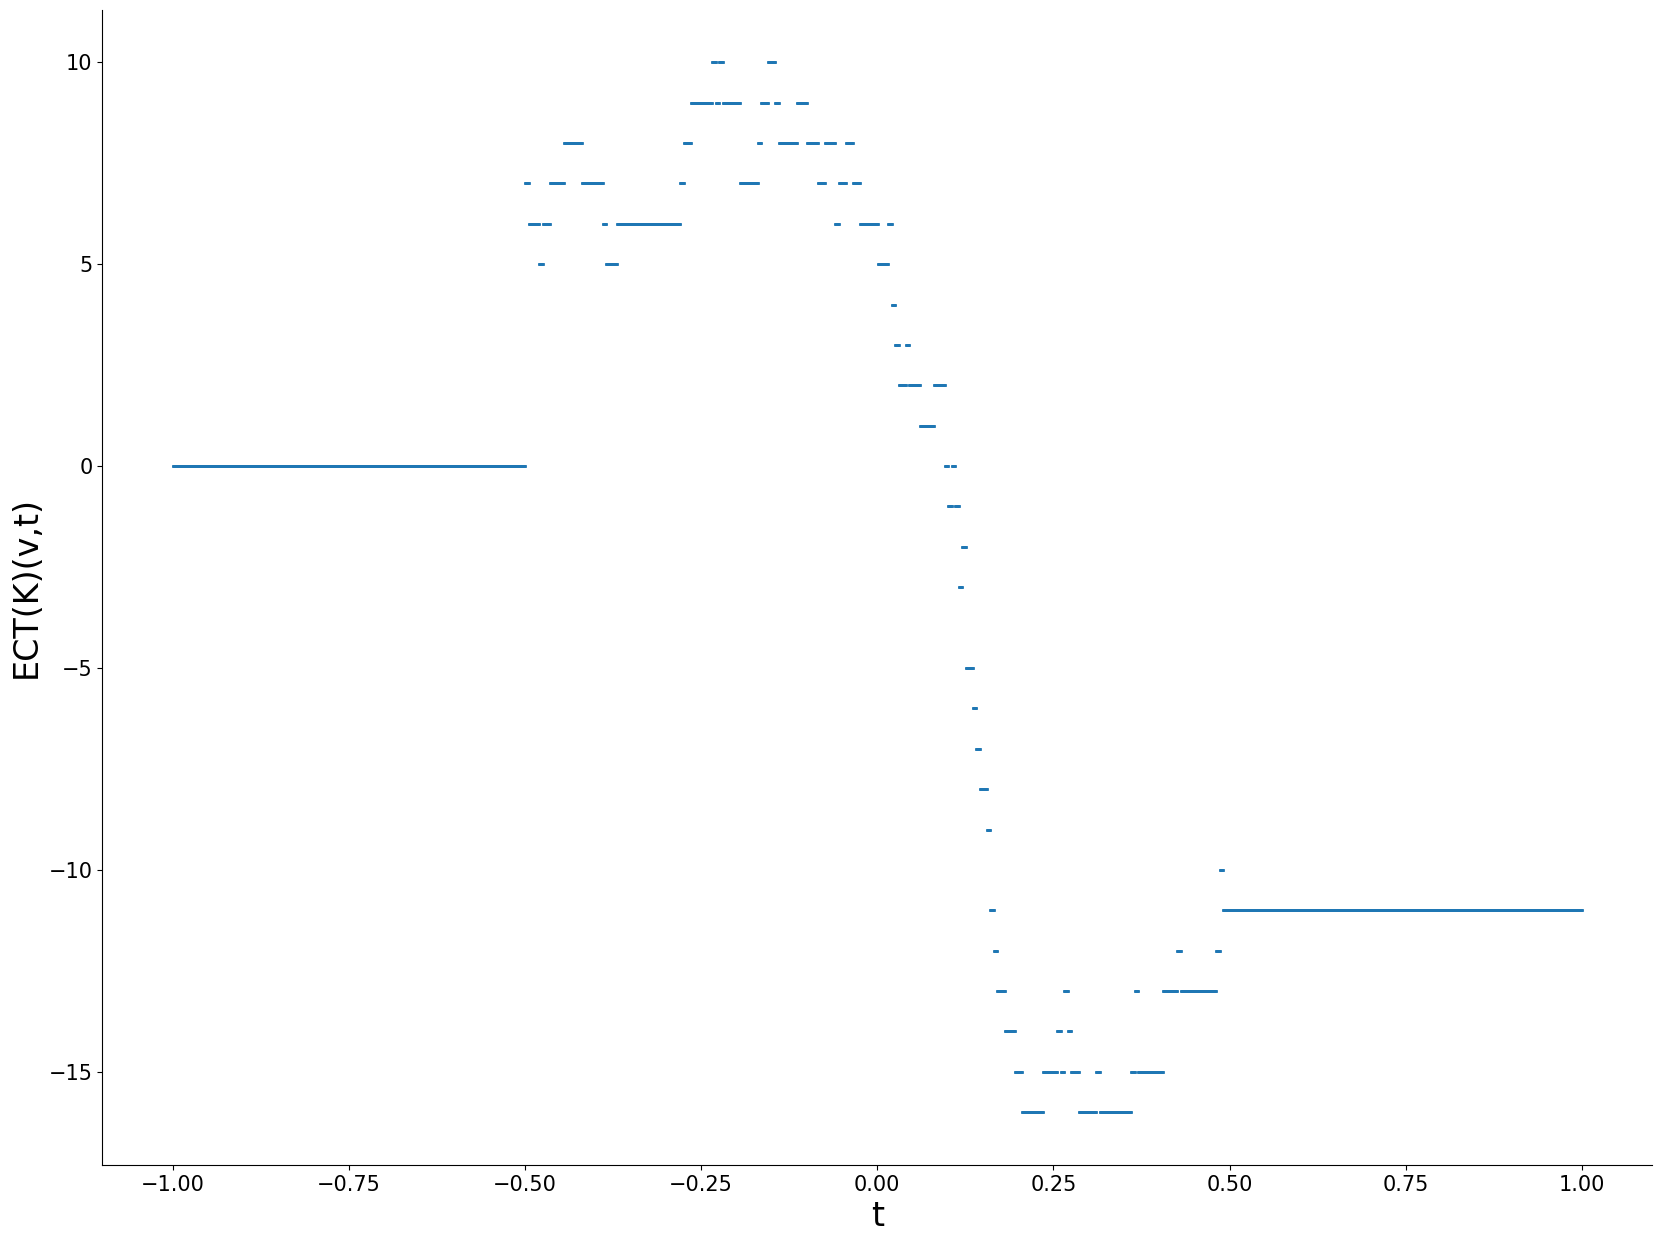

In [33]:
import matplotlib.pyplot as plt

# Example data setup (replace with your actual data)
ect_curves = [ect.flatten()]
x_values = T
fig, ax = plt.subplots(figsize=(20,15))

for i, curve in enumerate(ect_curves):
    color = f'C{i}'
    # Draw horizontal segments from (x_i, y_i) to (x_{i+1}, y_i)
    for xi, yi, xi_next in zip(x_values[:-1], curve[:-1], x_values[1:]):
        ax.plot([xi, xi_next], [yi, yi], color=color, linewidth=2)
    # Scatter the points
    ax.scatter(x_values, curve, color=color, s=0.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Only show ticks on bottom and left
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Labels
ax.set_xlabel('t', fontsize=24)
ax.set_ylabel('ECT(K)(v,t)', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

## plotting each step

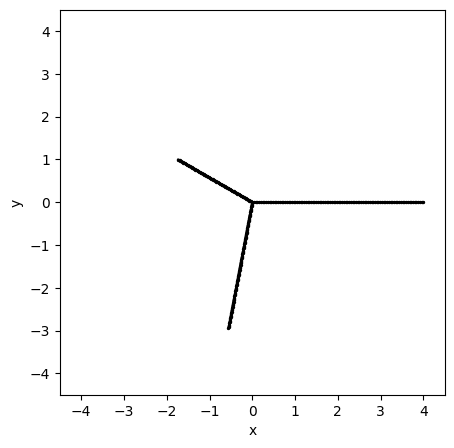

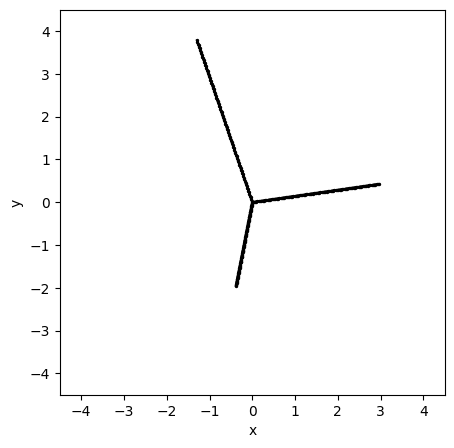

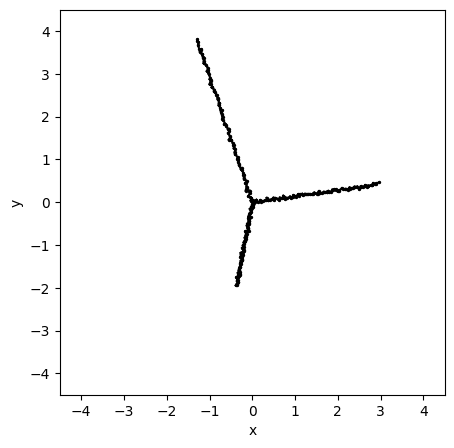

In [49]:
import numpy as np
import math
import matplotlib.pyplot as plt

def rotate_points_about_origin(points, angle):
    """
    Rotates each point in 'points' about the origin by 'angle' radians in-place.
    """
    R = np.array([[math.cos(angle), -math.sin(angle)],
                  [math.sin(angle),  math.cos(angle)]])
    for i in range(len(points)):
        points[i] = R @ points[i]

def generate_noisy_three_edges_shared_origin_with_rotation(n, noise_std=0.01, seed=None):
    """
    Generates and plots a three-edge simplicial complex in three steps:
      1) Base shape
      2) After single rotation
      3) After adding Gaussian noise
    
    All three plots share identical axis limits.
    
    :param n: Number of points per edge (including origin)
    :param noise_std: Std dev of Gaussian noise
    :param seed: RNG seed
    :return: (noisy_points, simplices)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # 1) Build base points
    edge_lengths = [2.0, 3.0, 4.0]
    edge_angles  = np.random.uniform(0, 2*math.pi, size=3)
    
    base = [[0.0, 0.0]]
    for L, θ in zip(edge_lengths, edge_angles):
        for j in range(1, n):
            frac = j / (n-1)
            base.append([L*frac*math.cos(θ), L*frac*math.sin(θ)])
    base_points = np.array(base)
    
    # 2) Build simplices template
    num_v = base_points.shape[0]
    simplices = []
    # 0-simplices
    for i in range(num_v):
        simplices.append([i])
    # 1-simplices
    for e in range(3):
        start = 1 + e*(n-1)
        simplices.append([0, start])
        for v in range(start, start + (n-2)):
            simplices.append([v, v+1])
    
    # 3) Prepare rotated & noisy versions
    θ_rot = np.random.uniform(0, 2*math.pi)
    rotated_points = base_points.copy()
    rotate_points_about_origin(rotated_points, θ_rot)
    noisy_points = rotated_points.copy()
    noise = np.random.normal(scale=noise_std, size=noisy_points.shape)
    noise[0] = 0
    noisy_points += noise
    
    # 4) Compute shared axis limits
    all_pts = np.vstack([base_points, rotated_points, noisy_points])
    min_x, max_x = all_pts[:,0].min(), all_pts[:,0].max()
    min_y, max_y = all_pts[:,1].min(), all_pts[:,1].max()
    # add small margin
    xlim = (-4.5, 4.5)
    ylim = (-4.5, 4.5)
    
    # helper for plotting
    def plot_stage(pts, title):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(pts[:,0], pts[:,1], color='black', s=2)
        for s in simplices:
            if len(s)==2:
                seg = pts[s]
                ax.plot(seg[:,0], seg[:,1], 'k-')
        ax.set_aspect('equal')
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_xlabel('x'); ax.set_ylabel('y')
        plt.show()
    
    # 5) Plot all three steps
    plot_stage(base_points,     "1) Base three-edge shape")
    plot_stage(rotated_points,  f"2) After rotation by {θ_rot:.2f} rad")
    plot_stage(noisy_points,    f"3) After adding noise (σ={noise_std})")
    
    return noisy_points, simplices

# Example usage:
noisy_pts, sims = generate_noisy_three_edges_shared_origin_with_rotation(
    n=100, noise_std=0.02, seed=1
)



## plots for MPEG-7

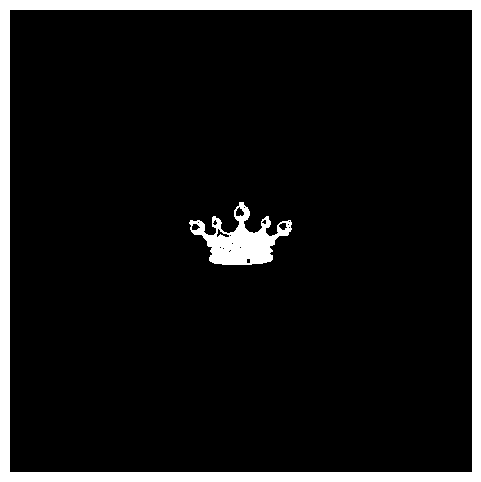

In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label

def filter_to_largest_cc(img_array):
    """
    Filters the binary image to keep only the largest connected component.
    This function first creates a boolean mask identifying white pixels (values > 0),
    then labels connected regions using an 8-connected neighborhood. It determines which 
    connected component is largest (by pixel count) and returns a new image where only 
    that component is retained as white (1), while all other pixels are set to 0.
    
    Parameters:
        img_array : np.array
            Input binary image array (with values 0 or 1, or >0 for white).
    
    Returns:
        np.array
            A binary image with only the largest connected white component.
    """
    # Create a boolean mask for white pixels.
    mask = img_array > 0
    # Label connected components using an 8-connected structure.
    labeled_array, num_features = label(mask, structure=np.ones((3, 3)))
    
    # If there are no white pixels (no connected component), return an array of zeros.
    if num_features == 0:
        return np.zeros_like(img_array)
    
    # Count the number of pixels in each connected component.
    component_sizes = np.bincount(labeled_array.ravel())
    
    # The background is labeled 0, so find the largest component among the non-background labels.
    if len(component_sizes) > 1:
        largest_component = np.argmax(component_sizes[1:]) + 1  # +1 to adjust for the background index
    else:
        return np.zeros_like(img_array)
    
    # Create a new image that retains only the largest connected component.
    filtered_img = (labeled_array == largest_component)
    return filtered_img.astype(img_array.dtype)

def pad_image_to_square(img_array, target_length):
    """
    Pads a binary image (values 0 or 1) to a square of size target_length x target_length.
    The image is padded with zeros (black pixels) so that the average coordinate of
    all white pixels (pixels with a value > 0) is centered in the new image.
    
    Parameters:
        img_array : np.array
            Input binary image.
        target_length : int
            The size of the square output image.
    
    Returns:
        np.array
            The padded square image.
    """
    # Get the original dimensions.
    orig_height, orig_width = img_array.shape[0:2]
    
    # Identify white pixels (values > 0)
    white_pixels = np.argwhere(img_array > 0)
    if white_pixels.size == 0:
        # If there are no white pixels, default to the center of the original image.
        centroid = np.array([orig_height / 2.0, orig_width / 2.0])
    else:
        # Compute the centroid of the white pixels.
        centroid = white_pixels.mean(axis=0)
    
    # Define the center of the target square.
    target_center = np.array([target_length / 2.0, target_length / 2.0])
    # Compute the offset needed to shift the white pixel centroid to the center.
    offset = np.round(target_center - centroid).astype(int)
    
    # Create a new square image of target_length filled with zeros (black).
    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    
    # Compute destination coordinates for pasting.
    paste_row = offset[0]
    paste_col = offset[1]
    dest_row_start = max(0, paste_row)
    dest_col_start = max(0, paste_col)
    dest_row_end = min(target_length, paste_row + orig_height)
    dest_col_end = min(target_length, paste_col + orig_width)
    
    # Calculate the source region from the original image that is to be copied.
    src_row_start = max(0, -paste_row)
    src_col_start = max(0, -paste_col)
    src_row_end = src_row_start + (dest_row_end - dest_row_start)
    src_col_end = src_col_start + (dest_col_end - dest_col_start)
    
    # Paste the computed region into the new padded image.
    new_img[dest_row_start:dest_row_end, dest_col_start:dest_col_end] = \
        img_array[src_row_start:src_row_end, src_col_start:src_col_end]
    
    return new_img

# --- Sample Plot Code Using the Filter Function ---

# Example: choose a particular image file in the current directory.
directory = "/Users/hyang/Desktop/original"
filename  = "crown-18.gif"

# 2) Build the full path
file_path = os.path.join(directory, filename)

# 3) Open with PIL, handling animated GIFs by grabbing the first frame
with Image.open(file_path) as img:
    try:
        img.seek(0)
    except EOFError:
        pass
    img_array = np.array(img)

# First, filter the image to keep only the largest connected component.
filtered_img = filter_to_largest_cc(img_array)

# For demonstration, determine a target length.
# In full processing, this might be computed as (max_dim + 10).
target_length = 1182

# Pad the filtered image.
padded_img = pad_image_to_square(filtered_img, target_length)

# Plot the padded image.
plt.figure(figsize=(6, 6))
plt.imshow(padded_img, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()


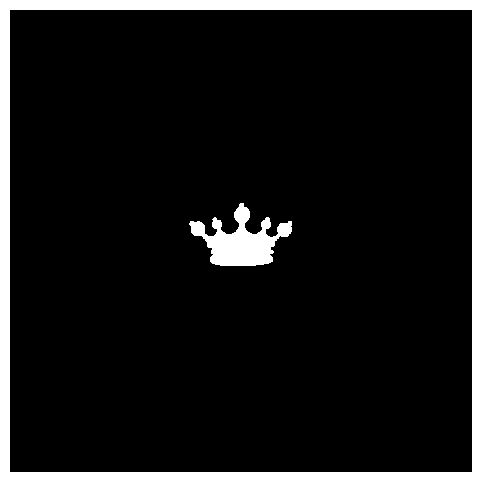

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label, binary_fill_holes

def filter_to_largest_cc(img_array):
    """
    Fills holes in the binary image, then filters to keep only the largest connected component.
    """
    # 1) Create a boolean mask for white pixels
    mask = img_array > 0

    # 2) Fill any holes inside the mask
    filled = binary_fill_holes(mask)

    # 3) Label connected components (8-connected)
    labeled_array, num_features = label(filled, structure=np.ones((3, 3)))

    # 4) If nothing found, return zeros
    if num_features == 0:
        return np.zeros_like(img_array)

    # 5) Find sizes of each component
    component_sizes = np.bincount(labeled_array.ravel())

    # 6) Identify largest non-background component
    if len(component_sizes) > 1:
        largest_cc = np.argmax(component_sizes[1:]) + 1
    else:
        return np.zeros_like(img_array)

    # 7) Return only the largest CC as a binary image
    filtered = (labeled_array == largest_cc)
    return filtered.astype(img_array.dtype)

def pad_image_to_square(img_array, target_length):
    """
    Pads the (filtered & hole-filled) binary image to a target_length×target_length square,
    centering on the centroid of the white pixels.
    """
    orig_h, orig_w = img_array.shape
    white_pixels = np.argwhere(img_array > 0)

    if white_pixels.size == 0:
        centroid = np.array([orig_h / 2.0, orig_w / 2.0])
    else:
        centroid = white_pixels.mean(axis=0)

    target_center = np.array([target_length / 2.0, target_length / 2.0])
    offset = np.round(target_center - centroid).astype(int)

    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)

    pr, pc = offset
    dr0 = max(0, pr)
    dc0 = max(0, pc)
    dr1 = min(target_length, pr + orig_h)
    dc1 = min(target_length, pc + orig_w)

    sr0 = max(0, -pr)
    sc0 = max(0, -pc)
    sr1 = sr0 + (dr1 - dr0)
    sc1 = sc0 + (dc1 - dc0)

    new_img[dr0:dr1, dc0:dc1] = img_array[sr0:sr1, sc0:sc1]
    return new_img

# --- Example Usage ---

directory     = "/Users/hyang/Desktop/original"
filename      = "crown-18.gif"
file_path     = os.path.join(directory, filename)

# Load first frame of GIF
with Image.open(file_path) as img:
    try:
        img.seek(0)
    except EOFError:
        pass
    img_array = np.array(img)

# 1) Fill holes & keep largest CC
filtered_img = filter_to_largest_cc(img_array)

# 2) Pad to square
target_length = 1182
padded_img    = pad_image_to_square(filtered_img, target_length)

# 3) Display
plt.figure(figsize=(6, 6))
plt.imshow(padded_img, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()


Processed children-3.gif → /Users/hyang/Desktop/original/processed/children-3.gif
Processed face-5.gif → /Users/hyang/Desktop/original/processed/face-5.gif
Processed watch-9.gif → /Users/hyang/Desktop/original/processed/watch-9.gif
Processed apple-5.gif → /Users/hyang/Desktop/original/processed/apple-5.gif
Processed pencil-12.gif → /Users/hyang/Desktop/original/processed/pencil-12.gif
Processed dog-16.gif → /Users/hyang/Desktop/original/processed/dog-16.gif
Processed lmfish-1.gif → /Users/hyang/Desktop/original/processed/lmfish-1.gif
Processed bat-10.gif → /Users/hyang/Desktop/original/processed/bat-10.gif
Processed teddy-20.gif → /Users/hyang/Desktop/original/processed/teddy-20.gif
Processed key-20.gif → /Users/hyang/Desktop/original/processed/key-20.gif
Processed teddy-08.gif → /Users/hyang/Desktop/original/processed/teddy-08.gif
Processed device6-9.gif → /Users/hyang/Desktop/original/processed/device6-9.gif
Processed chicken-16.gif → /Users/hyang/Desktop/original/processed/chicken-1

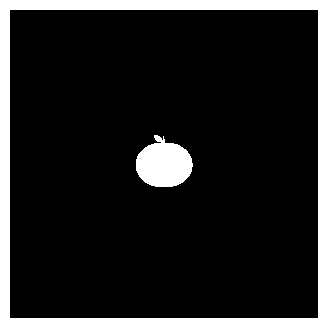

In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label, binary_fill_holes

def filter_to_largest_cc(img_array):
    mask   = img_array > 0
    filled = binary_fill_holes(mask)
    labeled, num = label(filled, structure=np.ones((3,3)))
    if num == 0:
        return np.zeros_like(img_array)
    sizes = np.bincount(labeled.ravel())
    if len(sizes) <= 1:
        return np.zeros_like(img_array)
    largest = np.argmax(sizes[1:]) + 1
    return (labeled == largest).astype(img_array.dtype)

def pad_image_to_square(img_array, target_length):
    h, w = img_array.shape
    white = np.argwhere(img_array > 0)
    if white.size == 0:
        centroid = np.array([h/2.0, w/2.0])
    else:
        centroid = white.mean(axis=0)
    center = np.array([target_length/2.0, target_length/2.0])
    offset = np.round(center - centroid).astype(int)

    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    pr, pc = offset
    dr0, dc0 = max(0, pr), max(0, pc)
    dr1 = min(target_length, pr + h)
    dc1 = min(target_length, pc + w)
    sr0, sc0 = max(0, -pr), max(0, -pc)
    sr1 = sr0 + (dr1 - dr0)
    sc1 = sc0 + (dc1 - dc0)

    new_img[dr0:dr1, dc0:dc1] = img_array[sr0:sr1, sc0:sc1]
    return new_img

# --- Batch processing all GIFs in a directory ---

source_dir = "/Users/hyang/Desktop/original"
processed_dir = os.path.join(source_dir, "processed")
os.makedirs(processed_dir, exist_ok=True)

# Decide on your square size here (e.g. max dimension + padding)
# If you want it dynamic per-image, you could compute inside the loop.
target_length = 1182  

for fname in os.listdir(source_dir):
    if not fname.lower().endswith(".gif"):
        continue

    in_path  = os.path.join(source_dir, fname)
    out_path = os.path.join(processed_dir, fname)

    # Load first frame
    with Image.open(in_path) as img:
        try:
            img.seek(0)
        except EOFError:
            pass
        arr = np.array(img)

    # If it’s multi-channel, convert to grayscale
    if arr.ndim == 3:
        # Simple average; or use more sophisticated conversion if you like
        arr = arr.mean(axis=2).astype(arr.dtype)

    # Process
    filtered = filter_to_largest_cc(arr)
    padded  = pad_image_to_square(filtered, target_length)

    # Scale binary 0/1 up to 0/255 for saving
    save_arr = (padded * 255).astype(np.uint8)
    Image.fromarray(save_arr).save(out_path)

    print(f"Processed {fname} → {out_path}")

# (Optional) Display one example
plt.figure(figsize=(4,4))
plt.imshow(save_arr, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()
